# Normalization

Этапы:
* Background correction (Первичная отчистака данных от мусора и шумов)
* Normalization (Нормализация экспресии генов) 
* Summarization (Преобразование в статистические величины) 

https://math.usu.edu/jrstevens/stat5570/1.4.preprocess_4up.pdf

In [1]:
# Установка пакетов oligo, oligoData
# Можно этот пункт пропустить, если у Вас пакеты
# oligo и oligoData установлены
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("oligo")
BiocManager::install("oligoData")

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'oligo'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bit', 'bit64', 'data.table', 'dplyr', 'ff', 'GOSemSim', 'httr',
  'oligoClasses', 'ps', 'sys', 'tidyr'

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

Installing package(s) 'oligoData'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bit', 'bit64', 'data.table', 'dplyr', 'ff', 'GOSemSim', 'httr',
  'oligoClasses', 'ps', 'sys', 'tidyr'



In [1]:
# Загружаем библиотеки
library("oligo")
library("oligoData")
data(affyExpressionFS)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: oligoClasses

Welcome to oligoClasses version 1.50.0

Loading required package: Bi

Loading required package: RSQLite

Loading required package: DBI



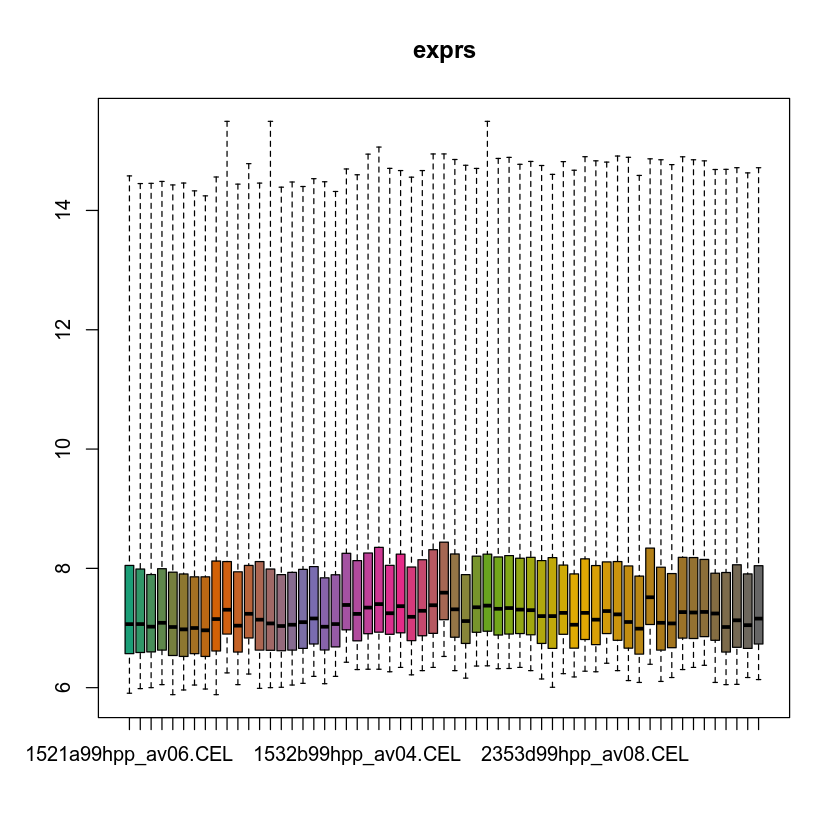

In [2]:
# Boxplot экспрессии генов
# График показывает среднее и первый и третий квартили
# A также разброс данных по каждому файлу
boxplot(affyExpressionFS)

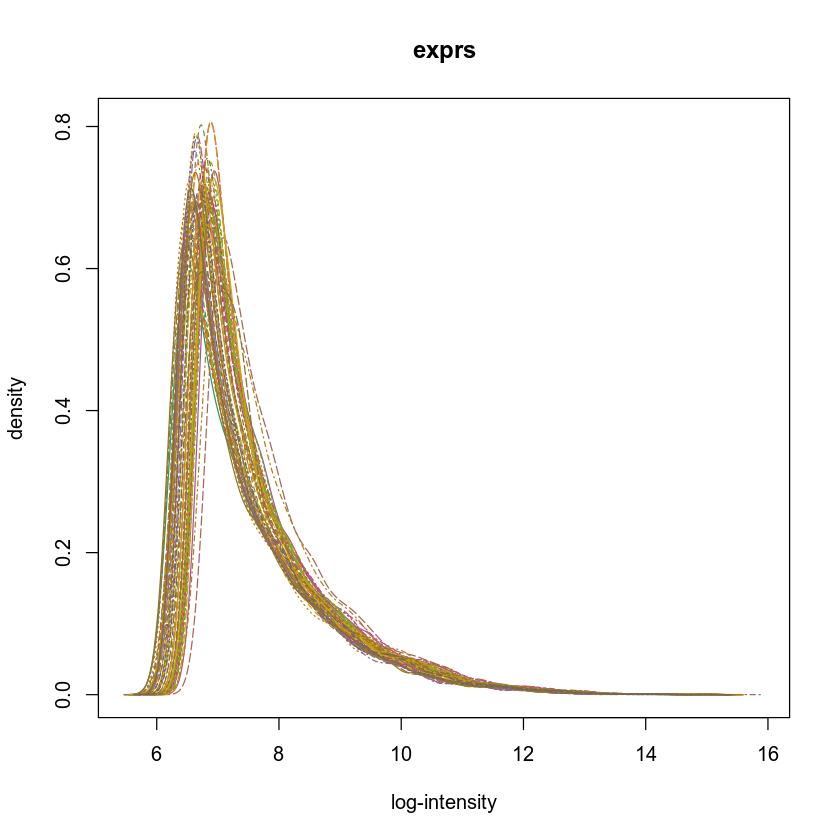

In [3]:
# Гистограмма экспрессии генов
# График показывает распределение экспрессии генов
# по каждому файлу 
# В хороших данных 
hist(affyExpressionFS)

## Background correction

In [4]:
# Выводим все доступные методы background correction
backgroundCorrectionMethods()

[1] "rma"  "mas"  "LESN"

### RMA

* RMA может обнаруживать истинный/биологический сигнал
* Работает только с позитивными значениями
* Работает только для One Color Data экспериментов (как правило Affymetrix)
* Сохраняет эффект чипа
* RMA может применяться к "сырым" данным
* За основу использует алгоритм MAS4 

Background correcting... 
OK



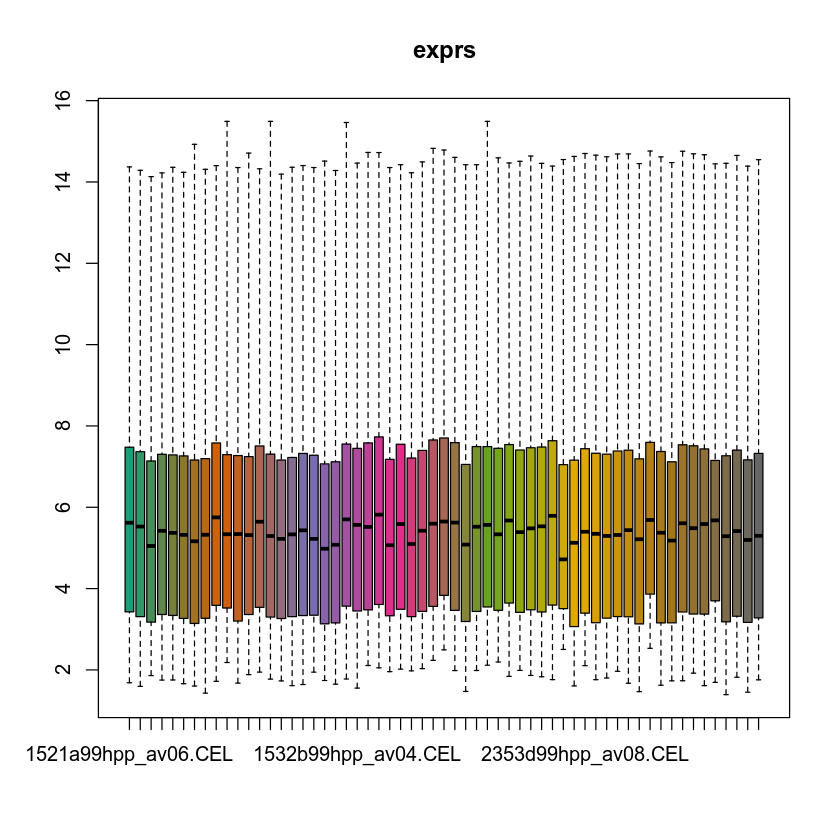

In [5]:
rma_affy <- backgroundCorrect(affyExpressionFS, method='rma')
boxplot(rma_affy)

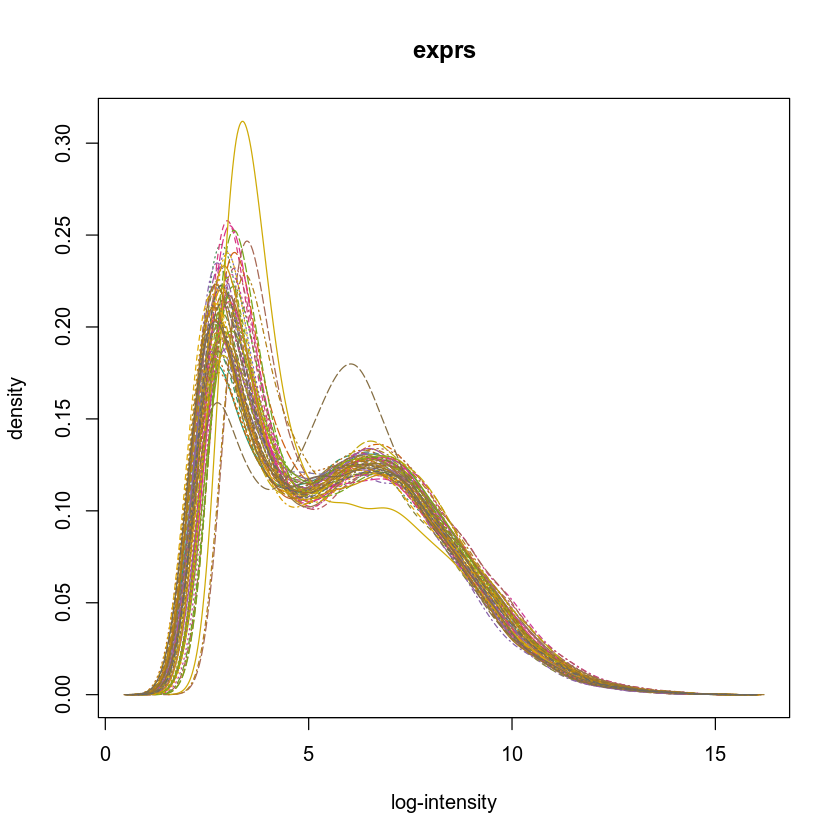

In [6]:
hist(rma_affy)

### MAS5

* Проделжение алгоритма MAS4 (Усреднение абсолютных значений)
* Добавлена нормализация по статистике Tukey's biweight (Просто раньше у этого алгоритма были 
проблемы с тем, что у него происходила очень частая потеря биологического сигнала и иногда он сам создавал шум, если значения были не велики)
* Есть статьи, которые утверждают, что RMA работает лучше, чем MAS5

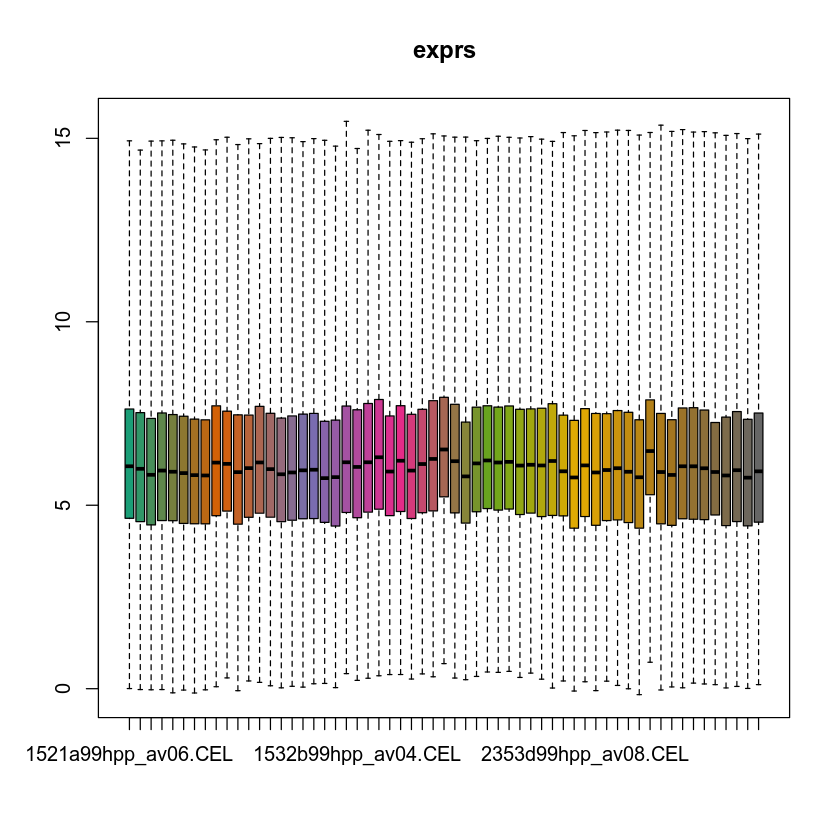

In [7]:
mas_affy <- backgroundCorrect(affyExpressionFS, method='mas') 
boxplot(mas_affy)

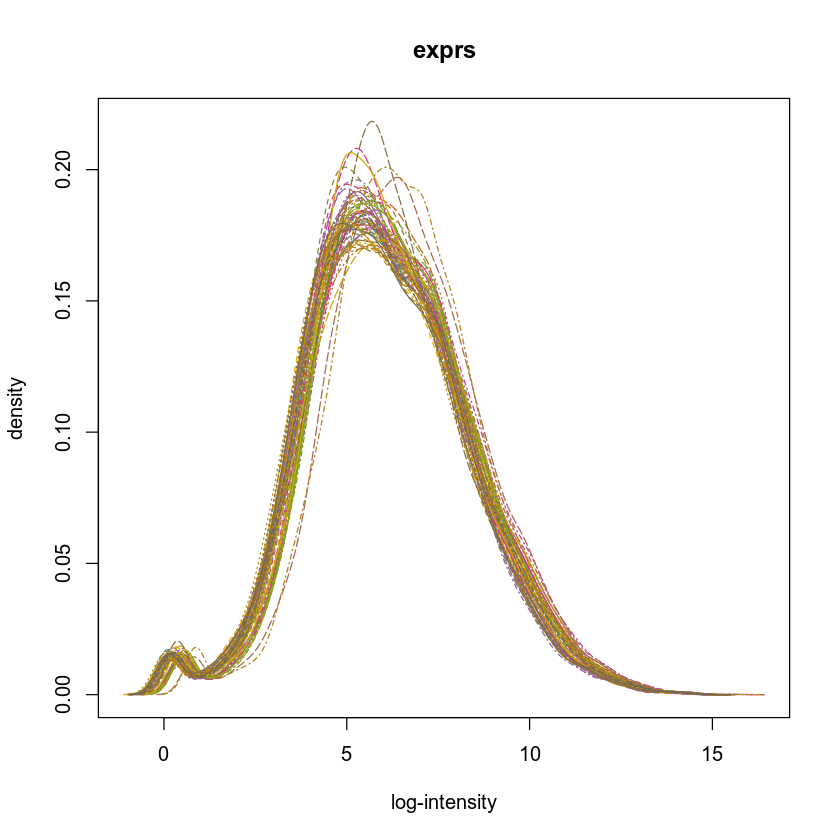

In [8]:
# Видно, что алгоритм не очень хорошо справился с задачей
hist(mas_affy)

## Normalization

In [9]:
# Выводим все методы нормализации
# Но мы рассмотрим quantile
oligo::normalizationMethods()

[1] "quantile"           "quantile.robust"    "quantile.in.blocks"
[4] "qspline"            "loess"              "invariantset"      
[7] "constant"

Здесь можно немного запутаться. Дело в том, что у некоторых нормализаций в частности **RMA** основные моменты выходят за рамки структуры нормалиазции, описанной выше. Поэтому в **normalizationMethods** есть методы, которые по идее являются **BackgroundCorrect** методами. Например, **loes**

In [10]:
norm.affy <- oligo::normalize(rma_affy)
norm.mas <- oligo::normalize(mas_affy)

Normalizing... 
OK

Normalizing... 
OK



In [17]:
?oligo::rma

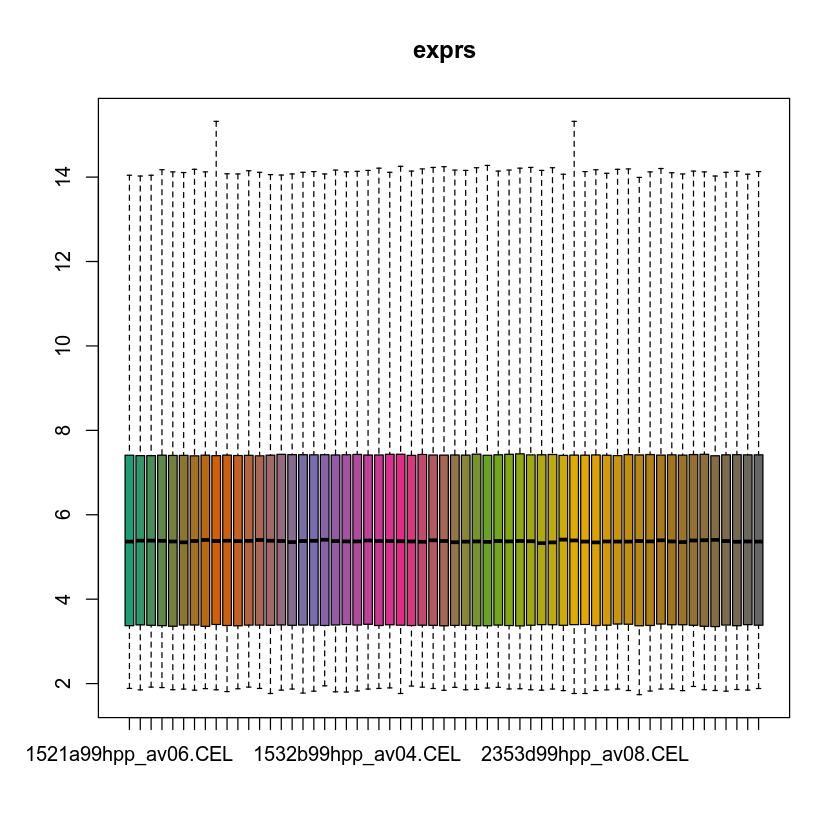

In [11]:
# Мы можем заметить, что среднее всех файлов стало примерно одинаковым
boxplot(norm.affy)

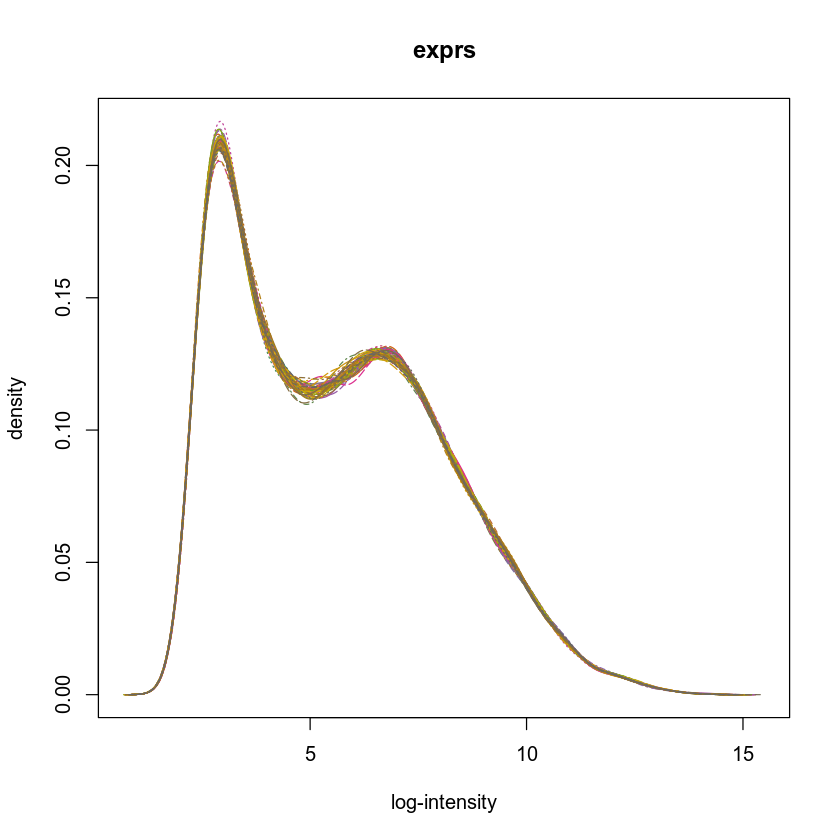

In [12]:
# Получилось более выраженное двух горбовое распределение
# Тем более сейчас не видно выбросов
hist(norm.affy)

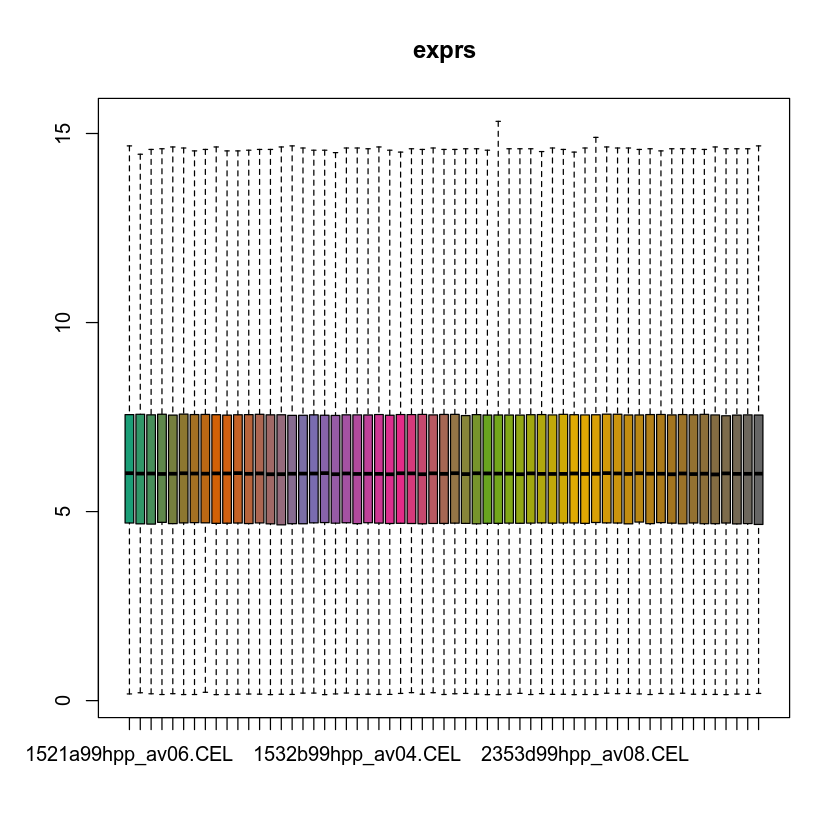

In [13]:
# Мы можем заметить, что среднее всех файлов стало примерно одинаковым
boxplot(norm.mas)

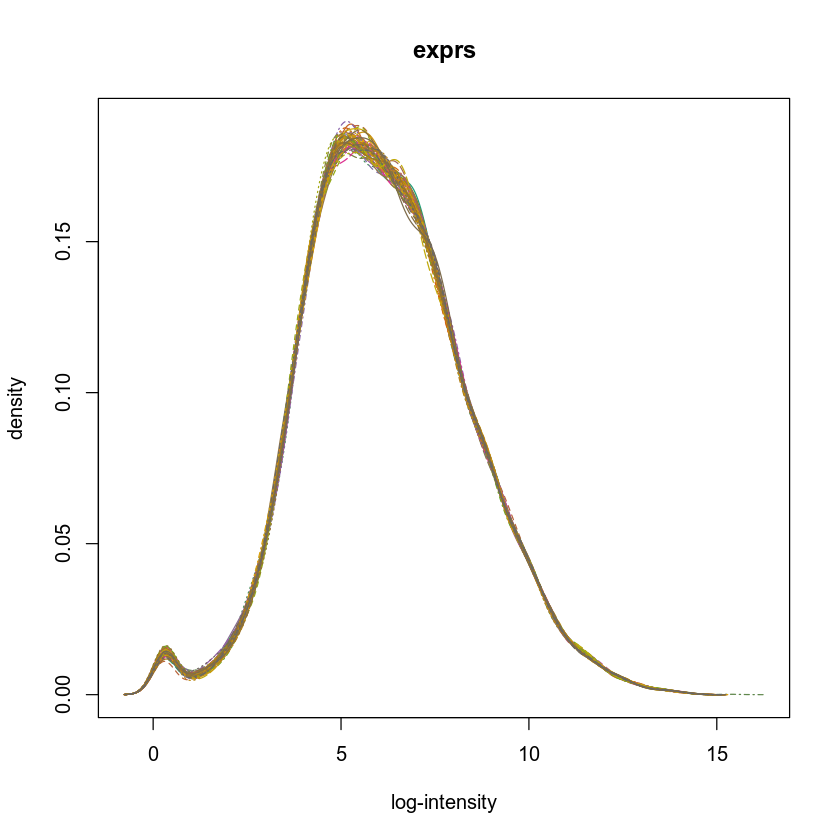

In [14]:
# Получилось более выраженное двугорбовое распределение, хотя все равно выглядит плохо
hist(norm.mas)

In [34]:
?normalize

### Полная нормализация rma

Пришло время рассказать о том, как на самом деле состоит нормализация end-to-end

Этапы:
1. RMA (Background normalization)
2. Quantile normalization (Пример работы смотрите здесь со слайда 24 http://www.ub.edu/stat/docencia/bioinformatica/microarrays/ADM/slides/2_PreprocessingMicroarrayData-2-Preprocessing%20and%20Normalization.pdf)
3. Summarization (Итеративно данные нормализуются по медиане сэмплов, потом по медиане генов до тех пор, пока
медианы не сойдутся. Если этот цикл бесконечен, то ограничиваются 5 итерациями)

In [35]:
rma.data <- rma(affyExpressionFS)

Background correcting
Normalizing
Calculating Expression


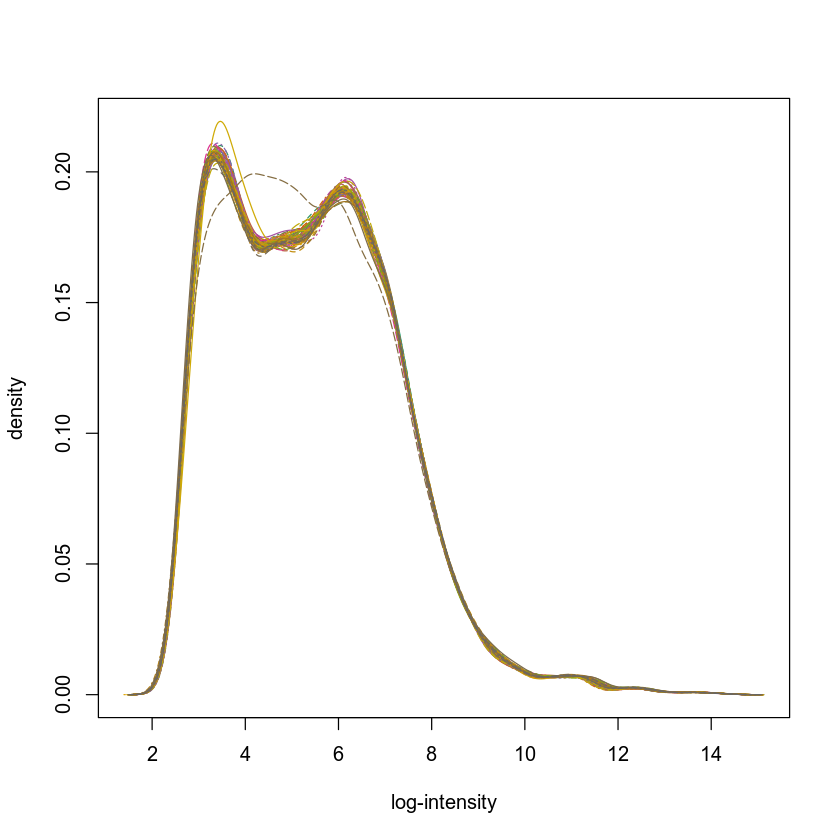

In [41]:
hist(rma.data)

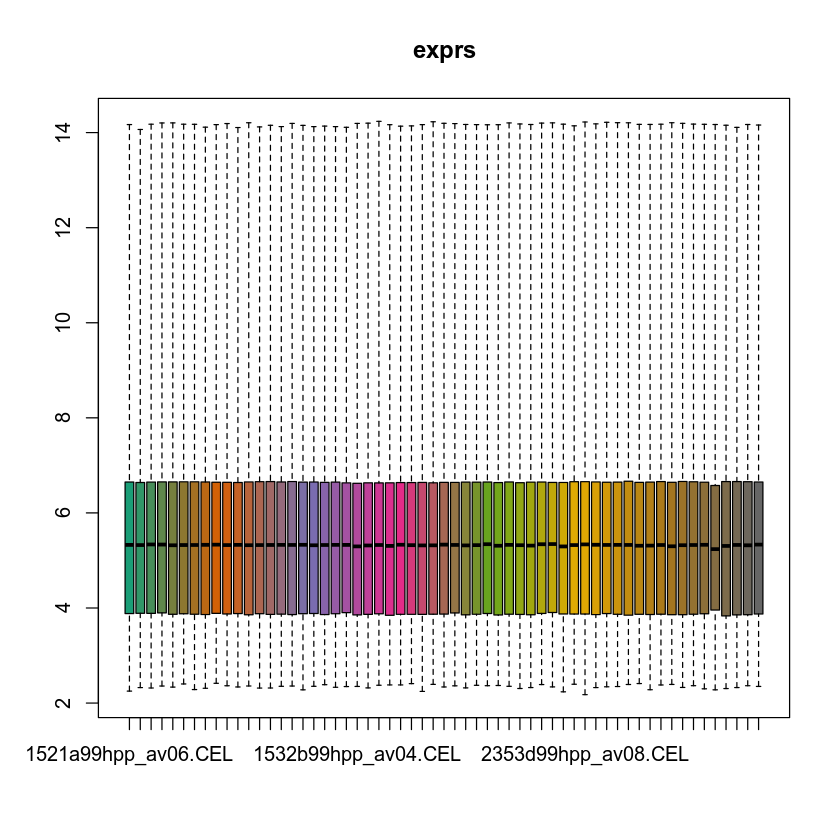

In [38]:
boxplot(rma.data)